In [1]:
from src.modelmodule.seg import SegModel
from src.datamodule.seg import SegDataModule
from pytorch_lightning import Trainer, seed_everything
import matplotlib.pyplot as plt
import torch
from omegaconf import OmegaConf, DictConfig
import hydra

# 用于初始化 Hydra 并且合成配置的函数
def init_hydra():
    with hydra.initialize(config_path="run/conf", version_base="1.2"):
        # 这里我们使用 compose 而不是 hydra.main
        cfg = hydra.compose(config_name="train")
        return cfg

# 执行代码
cfg = init_hydra()

cfg.accelerator = 'cpu'
cfg.duration = 17280
cfg.downsample_rate = 2
cfg.batch_size = 3
cfg.sigma = 10
cfg.decoder.dropout=0.2 
cfg.post_process.score_th=0.502 
cfg.post_process.distance=64 
cfg.loss=DictConfig({"name": "MSE"})
# cfg.feature_extractor=DictConfig({
#     "name": "PANNsFeatureExtractor",
#     "base_filters": 64,
#     "kernel_sizes": [
#       32,
#       16,
#       3
#     ],
#     "stride": 3,
#     "sigmoid": True,
#     "reinit": True,
#     "win_length": None
#   })
cfg.model.unet_class="DeepLabV3Plus" 
cfg.model.encoder_name="efficientnet-b2"


# additional_cfg = OmegaConf.load(f"run/conf/feature_extractor/{cfg.feature_extractor}.yaml")
# print(OmegaConf.merge(cfg, additional_cfg))

seed_everything(cfg.seed)
print(cfg)
# 初始化 lightning 数据模块和模型
datamodule = SegDataModule(cfg)
model = SegModel(
    cfg, datamodule.valid_event_df, len(cfg.features), len(cfg.labels), cfg.duration
)
# weight_path = 'output/train/exp005/single/child-mind-institute-detect-sleep-states/itphhvr1/checkpoints/epoch=25-step=3094.ckpt'
# weight_path = 'output/train/exp005/single/best_model.pth'
weight_path = 'output/train/exp024/run1/child-mind-institute-detect-sleep-states/lo9s9uts/checkpoints/epoch=14-step=5715.ckpt'
model.load_state_dict(torch.load(weight_path)['state_dict'])
spec2dcnn = model.model
# spec2dcnn.load_state_dict(torch.load(weight_path)['state_dict']['model'])

/home/ljb/miniconda3/envs/new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


{'model_sigmod': False, 'output_sigmod': True, 'output_clip': False, 'seed': 42, 'exp_name': 'dummy', 'duration': 17280, 'downsample_rate': 2, 'upsample_rate': 1, 'epoch': 50, 'batch_size': 3, 'num_workers': 24, 'accelerator': 'cpu', 'use_amp': True, 'debug': False, 'gradient_clip_val': 0.1, 'accumulate_grad_batches': 1, 'monitor': 'val_score', 'monitor_mode': 'max', 'check_val_every_n_epoch': 1, 'offset': 10, 'sigma': 10, 'bg_sampling_rate': 0.5, 'augmentation': {'mixup_prob': 0.0, 'mixup_alpha': 0.4, 'cutmix_prob': 0.0, 'cutmix_alpha': 0.4}, 'post_process': {'score_th': 0.502, 'distance': 64}, 'labels': ['awake', 'event_onset', 'event_wakeup'], 'features': ['anglez', 'enmo', 'hour_sin', 'hour_cos'], 'optimizer': {'lr': 0.001}, 'scheduler': {'num_warmup_steps': 0}, 'loss': {'name': 'MSE'}, 'dir': {'data_dir': '/home/ljb/kaggle-child-mind-institute-detect-sleep-states/data', 'processed_dir': '/home/ljb/kaggle-child-mind-institute-detect-sleep-states/processed_data', 'output_dir': '/hom

FileNotFoundError: [Errno 2] No such file or directory: 'output/train/exp024/run1/child-mind-institute-detect-sleep-states/lo9s9uts/checkpoints/epoch=14-step=5715.ckpt'

In [ ]:
feature_extractor = spec2dcnn.feature_extractor
encoder = spec2dcnn.encoder
decoder = spec2dcnn.decoder

In [ ]:
train_dl = datamodule.train_dataloader()
batch = next(iter(train_dl)) #dict_keys(['series_id', 'feature', 'label'])

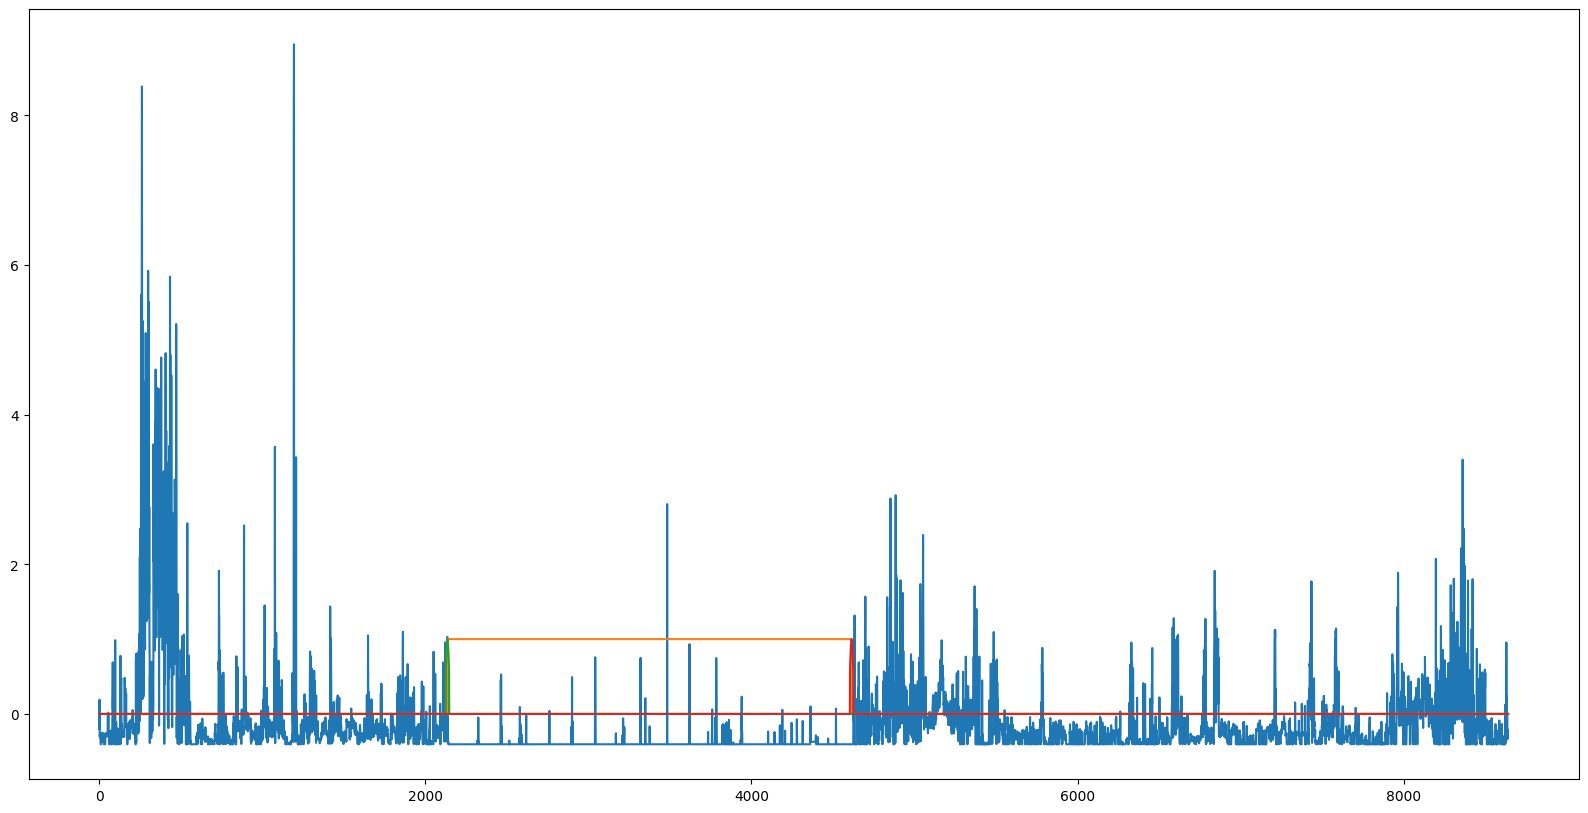

In [ ]:
idx = 0
s_id = batch['series_id'][idx]
x = batch['feature'][idx:idx+2]
y = batch['label'][idx]
fig = plt.figure(figsize=(20, 10))
plt.plot(x[idx, 1, ::cfg.downsample_rate])
plt.plot(y)
plt.show()

torch.Size([2, 8, 64, 8640])


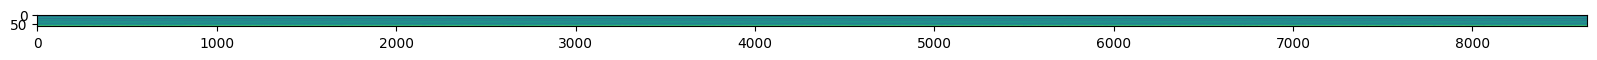

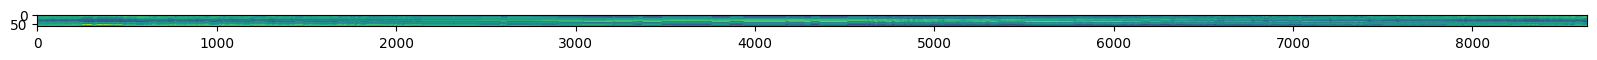

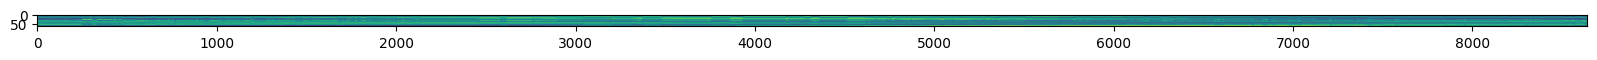

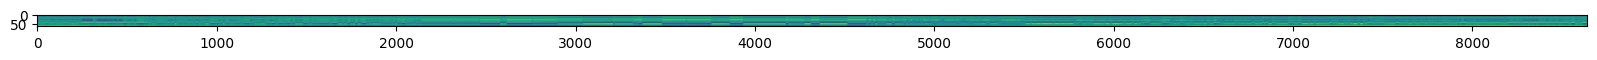

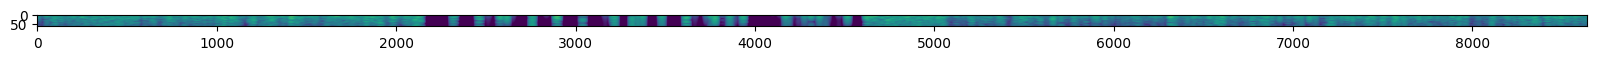

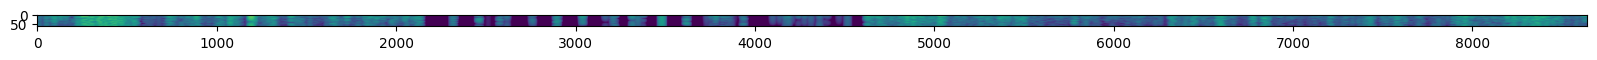

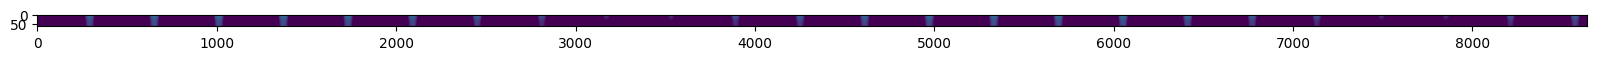

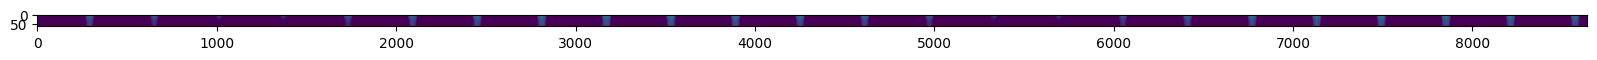

torch.Size([2, 64, 8640])


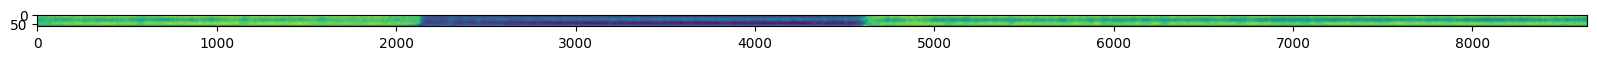

torch.Size([8640, 3])


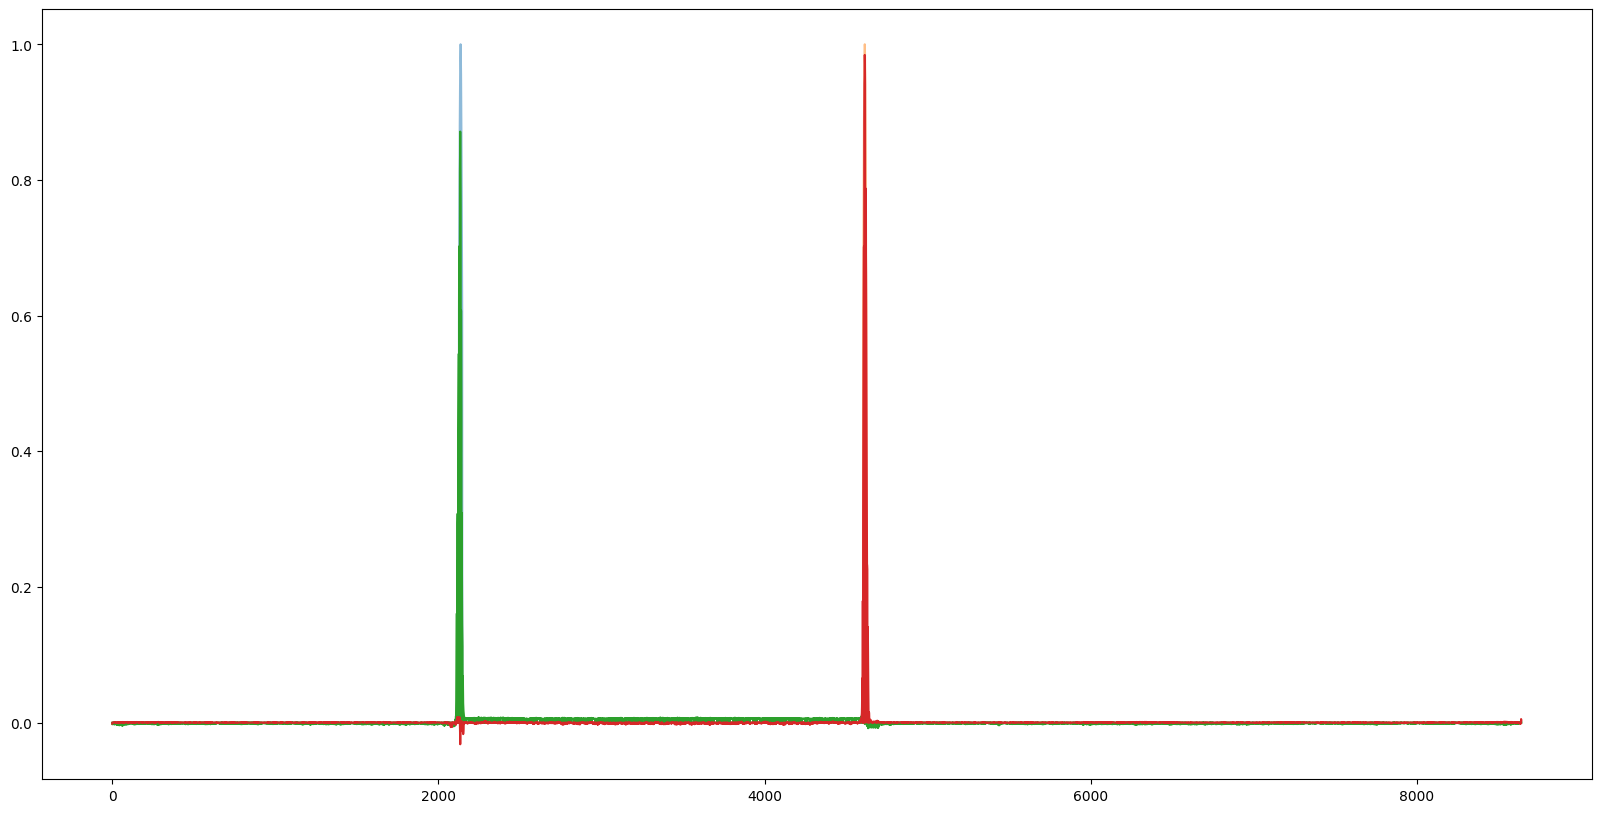

: 

In [ ]:
out = feature_extractor(x)  # (batch_size, n_channels, height, n_timesteps)
print(out.shape)
for i in range(8):
    plt.figure(figsize=(20, 10))
    plt.imshow(out[0, i, :, :].detach().numpy())
    plt.show()
out = encoder(out).squeeze(1)  # (batch_size, height, n_timesteps)
print(out.shape)
plt.figure(figsize=(20, 10))
plt.imshow(out[0, :, :].detach().numpy())
plt.show()
logits = decoder(out)[0]  # (batch_size, n_classes, n_timesteps)
print(logits.shape)
plt.figure(figsize=(20, 10))
plt.plot(y[:,1:], alpha=0.5)
for i in range(1,3):
    plt.plot(logits[:, i].detach().numpy())

plt.show()

torch.Size([8640, 3])


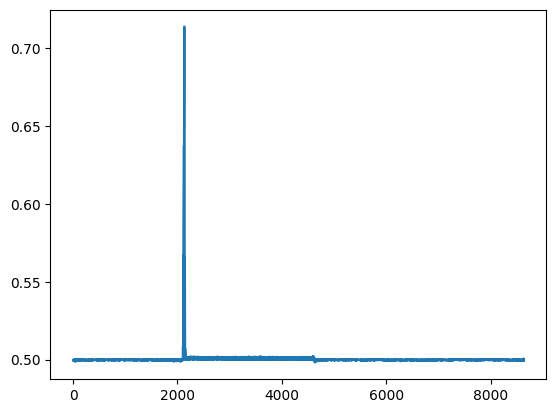

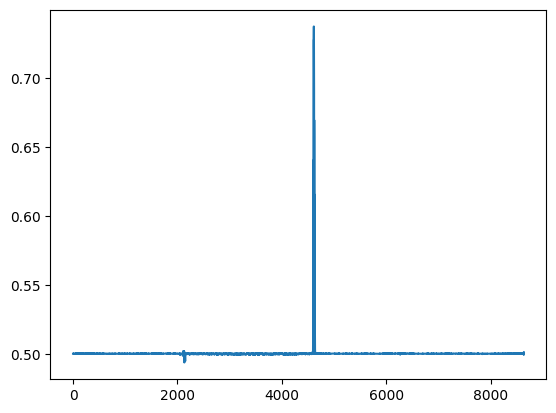

In [ ]:
pred = logits.sigmoid()
print(pred.shape)
# pred[torch.where(pred < 0.5001)] = 0
pred = pred.detach().numpy()
plt.plot(pred[::1,1:2])
# plt.plot(x[1, ::cfg.downsample_rate])
plt.show()
plt.plot(pred[::1,2:])
# plt.plot(x[1, ::cfg.downsample_rate])
plt.show()

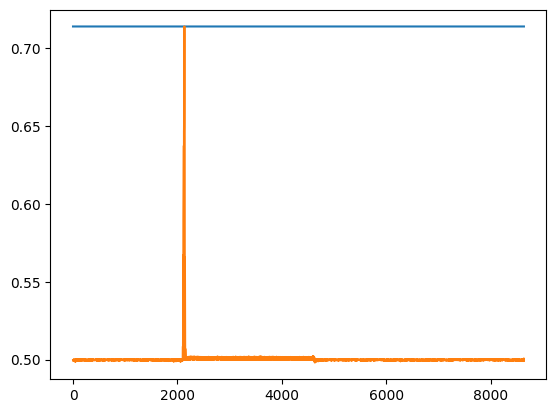

In [ ]:
import numpy as np
dim = 1
plt.plot(np.ones_like(pred[:,dim])*pred[:,dim].max())
plt.plot(pred[:,dim])
plt.show()

In [ ]:
from scipy.signal import find_peaks
find_peaks(pred[:,dim], height=0.02, distance=64)

(array([  14,   95,  181,  256,  340,  458,  543,  615,  700,  767,  873,
         980, 1078, 1188, 1257, 1368, 1478, 1558, 1632, 1760, 1830, 1918,
        1989, 2068, 2134, 2247, 2324, 2396, 2467, 2531, 2602, 2691, 2760,
        2852, 2939, 3052, 3120, 3199, 3278, 3360, 3466, 3588, 3666, 3749,
        3818, 3897, 3964, 4086, 4159, 4255, 4338, 4416, 4520, 4602, 4679,
        4743, 4811, 4876, 4951, 5026, 5109, 5233, 5319, 5422, 5518, 5617,
        5729, 5802, 5879, 5959, 6083, 6164, 6235, 6307, 6397, 6478, 6544,
        6626, 6700, 6771, 6849, 6930, 6999, 7063, 7128, 7197, 7291, 7399,
        7468, 7541, 7628, 7702, 7781, 7852, 7939, 8023, 8113, 8221, 8292,
        8385, 8450, 8556, 8637]),
 {'peak_heights': array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
         0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
         0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
         0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        

In [ ]:
pred

array([[0.5       , 0.49968928, 0.5       ],
       [0.5002138 , 0.4992577 , 0.5000049 ],
       [0.5       , 0.4997261 , 0.5       ],
       ...,
       [0.49955186, 0.5006846 , 0.49928433],
       [0.50022256, 0.5004326 , 0.5012391 ],
       [0.5       , 0.49909863, 0.5008099 ]], dtype=float32)